In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
hitting_df = pd.read_csv(PATH_TO_OUTPUT_DATA + 'COV_AGGREGATE.csv')
game_df = pd.read_csv(PATH_TO_OUTPUT_DATA + 'GAME_LEVEL.csv')

def convert_team_ids(team):
    if (team == 'LAA'):
        return 'ANA' # matches up with previous table
    if (team == 'FLO'):
        return 'MIA' # matches up with previous table
    if (team == 'MON'):
        return 'WAS' # matches up with previous table
    return team

hitting_df['team'] = hitting_df['team'].apply(convert_team_ids)
batting_df_test = hitting_df.copy()

In [10]:
pitching_df = pd.read_csv(PATH_TO_DATA + 'pitchers/Pitching.csv')
players_df = pd.read_csv(PATH_TO_DATA + 'pitchers/People.csv')[['playerID', 'retroID', 'bbrefID']]

In [27]:
pitching_df = pitching_df[pitching_df.yearID >= 2000] # don't need earlier data

def convert_team_ids(team):
    if (team == 'LAA'):
        return 'ANA' # matches up with previous table
    if (team == 'FLO'):
        return 'MIA' # matches up with previous table
    if (team == 'MON'):
        return 'WAS' # matches up with previous table
    return team

pitching_df.teamID = pitching_df.teamID.apply(convert_team_ids)

Brief examine to consider starting pitcher stats

In [72]:
starters_df = []
for i in [8, 10, 12, 15, 20, 25]:
    if (len(starters_df) == 0):
        starters_df = pitching_df[pitching_df.GS > i].groupby('yearID')['playerID'].count().rename(i).to_frame()
    else:
        starters_df = pd.concat([starters_df,
            pitching_df[pitching_df.GS > i].groupby('yearID')['playerID'].count().rename(i).to_frame()], axis = 1)

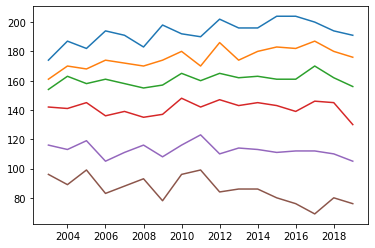

In [73]:
# Set starter = 12 starts per year
plt.plot(starters_df)

In [76]:
# starting pitchers
starters_df = pitching_df[pitching_df.GS > 12] # starting pitchers

In [78]:
starters_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
34898,affelje01,2003,1,KCA,AL,7,6,36,18,0,...,1.0,2,5.0,2,533.0,5,58,2.0,5.0,12.0
34909,anderbr02,2003,1,CLE,AL,9,10,25,24,0,...,3.0,2,4.0,1,623.0,0,88,2.0,10.0,17.0
34915,appieke01,2003,1,ANA,AL,7,7,19,19,0,...,4.0,4,8.0,1,422.0,0,60,0.0,1.0,3.0
34932,batismi01,2003,1,ARI,NL,10,9,36,29,2,...,3.0,7,8.0,0,822.0,5,85,10.0,6.0,22.0
34934,beckejo02,2003,1,MIA,NL,9,8,24,23,0,...,4.0,6,2.0,1,601.0,1,54,5.0,1.0,11.0


In [79]:
players_df.head()

,playerID,retroID,bbrefID
0,aardsda01,aardd001,aardsda01
1,aaronha01,aaroh101,aaronha01
2,aaronto01,aarot101,aaronto01
3,aasedo01,aased001,aasedo01
4,abadan01,abada001,abadan01


In [81]:
print(starters_df.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')


In [84]:
pitcher_df = starters_df.merge(players_df)[['retroID', 'yearID', 'teamID', 
                               'W', 'L', 'G', 'GS', 'IPouts',
                               'SO', 'BAOpp', 'ERA']].rename({
    'yearID': 'Y',
    'teamID': 'team',
    'IPouts': 'IP',
    'BAOpp': 'BAA'
}, axis = 1)

In [89]:
pitcher_df.to_csv(PATH_TO_OUTPUT_DATA + 'STARTING_PITCHERS.csv', index = False)

### Computing covariate priors

Determining each new season as the prior from the previous season

In [193]:
batting_df_test

,team,date,AB,RS,H,HR,TB,BB,SF
0,ANA,20000403,35,2,10,1,14,5,0
1,ANA,20000404,36,3,10,0,10,6,0
2,ANA,20000405,33,12,12,1,19,9,2
3,ANA,20000407,32,7,9,2,17,5,0
4,ANA,20000408,35,7,13,1,20,1,0
...,...,...,...,...,...,...,...,...,...
96140,WAS,20190925,33,3,8,2,15,1,0
96141,WAS,20190926,34,5,9,2,18,7,0
96142,WAS,20190927,34,6,11,2,20,4,0
96143,WAS,20190928,34,7,11,1,17,6,0


In [255]:
batting_df_test.reset_index(drop = True, inplace = True)
batting_df_test = batting_df_test.set_index('team')
batting_df_test['Y'] = batting_df_test.date.apply(lambda x: round(x/10000))
grouped_batting = batting_df_test.groupby(['team', 'Y']).sum()
avgs = grouped_batting['H']/grouped_batting['AB']

avg_reset = avgs.reset_index(level = 1).rename({0: 'VALUE'}, axis = 1)
avg_reset.head()

,Y,VALUE
team,,
ANA,2000,0.277406
ANA,2001,0.258070
ANA,2002,0.279707
ANA,2003,0.263318
ANA,2004,0.276666


In [256]:
def create_prior_variables(avg_reset):
    TABLE = pd.DataFrame(columns = ['Y'] + sorted(list(set(batting_df_test.index))))

    avg_year = {}
    for year in range(2001, 2020):
        avg_year['Y'] = year
        for team in sorted(list(set(batting_df_test.index))):
            # Find PREVIOUS YEAR
            avg_year[team] = avg_reset[avg_reset.Y == (year - 1)].loc[team, 'VALUE']
        TABLE = pd.concat([TABLE, pd.DataFrame(avg_year, index = [0])])

    return TABLE.set_index('Y')

TEAM_BATTING_AVG = create_prior_variables(avg_reset)


obp = ((grouped_batting['H'] + grouped_batting['BB'])/(
    grouped_batting['AB'] + grouped_batting['BB'] + grouped_batting['SF'])).reset_index(
    level = 1).rename({0: 'VALUE'}, axis = 1)
TEAM_BATTING_OBP = create_prior_variables(obp)

slg = ((grouped_batting['TB'])/(
    grouped_batting['AB'])).reset_index(
    level = 1).rename({0: 'VALUE'}, axis = 1)
TEAM_BATTING_SLG = create_prior_variables(slg)

In [257]:
TEAM_BATTING_AVG.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_AVG_PRIORS.csv')
TEAM_BATTING_OBP.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_OBP_PRIORS.csv')
TEAM_BATTING_SLG.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_SLG_PRIORS.csv')

### Computing input covariates

In [399]:
TEAM_BATTING_AVG = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_AVG_PRIORS.csv').set_index('Y')
TEAM_BATTING_OBP = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_OBP_PRIORS.csv').set_index('Y')
TEAM_BATTING_SLG = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/TEAM_SLG_PRIORS.csv').set_index('Y')

In [400]:
TEAM_BATTING_AVG.head()

,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
Y,,,,,,,,,,,,,,,,,,,,,
2001,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
2002,0.258070,0.264988,0.258724,0.245706,0.264248,0.264318,0.258674,0.259122,0.275783,0.288365,...,0.257843,0.244632,0.249187,0.285490,0.264248,0.267201,0.255743,0.273219,0.260140,0.250414
2003,0.279707,0.264542,0.258134,0.243740,0.273876,0.265538,0.243687,0.250724,0.246753,0.270931,...,0.256148,0.242080,0.250404,0.271839,0.264584,0.265622,0.250442,0.267493,0.258937,0.258858
2004,0.263318,0.258913,0.278586,0.262556,0.285788,0.259472,0.253633,0.239184,0.248987,0.261782,...,0.256783,0.261250,0.256087,0.267471,0.258621,0.272273,0.261043,0.262781,0.276678,0.253155
2005,0.276666,0.248669,0.265360,0.275726,0.278680,0.262775,0.262170,0.245902,0.268531,0.267517,...,0.261975,0.254821,0.268349,0.264746,0.264001,0.271783,0.253536,0.262537,0.256740,0.242732


In [401]:
AVG_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')
OBP_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')
SLG_COV_DF = pd.DataFrame(columns = ['date'] + sorted(list(set(batting_df_test.index)))).set_index('date')

In [402]:
dates = sorted(list(set(batting_df_test[batting_df_test.Y >= 2001]['date'])))
for i in range(len(dates)):
    AVG_COV_DF.loc[dates[i]] = 0
    OBP_COV_DF.loc[dates[i]] = 0
    SLG_COV_DF.loc[dates[i]] = 0

In [403]:
import time

In [404]:
start = time.time()
for year in range(2001, 2020):
    year_start = time.time()
    INPUT_DATA = batting_df_test[batting_df_test.Y == year]
    dates = sorted(list(set(INPUT_DATA['date']))) # dates for each year

    for team in sorted(list(set(INPUT_DATA.index))):
        prior_avg = TEAM_BATTING_AVG.loc[year, team]
        prior_obp = TEAM_BATTING_OBP.loc[year, team]
        prior_slg = TEAM_BATTING_SLG.loc[year, team]

        # finds data only for that specific team
        ROLLING_DATA = INPUT_DATA.loc[team].set_index('date').rolling(7).sum()
        ROLLING_DATA['AVG'] = ROLLING_DATA['H']/ROLLING_DATA['AB']
        ROLLING_DATA['OBP'] = (ROLLING_DATA['H'] + ROLLING_DATA['BB'])/(
            ROLLING_DATA['AB'] + ROLLING_DATA['BB'] + ROLLING_DATA['SF'])
        ROLLING_DATA['SLG'] = ROLLING_DATA['TB']/ROLLING_DATA['AB']

        # iterates over all dfs
        for i in range(len(dates)):
            if (i < 7):
                # set first 7 days to be the last year's average
                AVG_COV_DF.loc[dates[i]][team] = prior_avg
                OBP_COV_DF.loc[dates[i]][team] = prior_obp
                SLG_COV_DF.loc[dates[i]][team] = prior_slg
            else:
                # try setting to rolling average or previous day
                try:
                    if (ROLLING_DATA.loc[dates[i]]['AVG'] != ROLLING_DATA.loc[dates[i]]['AVG']):
                        # replace nulls
                        AVG_COV_DF.loc[dates[i]][team] = prior_avg
                        OBP_COV_DF.loc[dates[i]][team] = prior_obp
                        SLG_COV_DF.loc[dates[i]][team] = prior_slg
                    else:
                        AVG_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['AVG']
                        OBP_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['OBP']
                        SLG_COV_DF.loc[dates[i]][team] = ROLLING_DATA.loc[dates[i]]['SLG']

                        prior_avg = ROLLING_DATA.loc[dates[i]]['AVG']
                        prior_obp = ROLLING_DATA.loc[dates[i]]['OBP']
                        prior_slg = ROLLING_DATA.loc[dates[i]]['SLG']
                except:
                    # set the prior avg
                    AVG_COV_DF.loc[dates[i]][team] = prior_avg
                    OBP_COV_DF.loc[dates[i]][team] = prior_obp
                    SLG_COV_DF.loc[dates[i]][team] = prior_slg
    year_end = time.time()
    print('year ' + str(year) + ' took: ' + str(round((year_end - year_start)*1000)/1000))

year 2001 took: 5.669
year 2002 took: 6.151
year 2003 took: 5.695
year 2004 took: 5.653
year 2005 took: 5.962
year 2006 took: 5.998
year 2007 took: 5.513
year 2008 took: 5.48
year 2009 took: 5.468
year 2010 took: 6.424
year 2011 took: 5.703
year 2012 took: 5.42
year 2013 took: 5.994
year 2014 took: 5.413
year 2015 took: 5.599
year 2016 took: 5.913
year 2017 took: 5.809
year 2018 took: 5.99
year 2019 took: 5.819


In [405]:
# EXPORT
AVG_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_AVG.csv')
OBP_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_OBP.csv')
SLG_COV_DF.to_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_SLG.csv')

### Why we use covariate AVGs and rolling #'s
Now we want to combine pitcher data with our game-levels
Note that we only included the rolling stats because individual game-to-game predictions have too much variance

Rollign #'s hits don't mean anything...

0.10146878451798538
0.10367851373738675


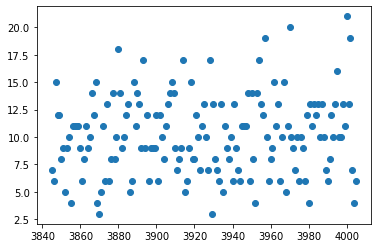

In [406]:
# see variance of Mariners in 2001
check_df = batting_df_test[batting_df_test.Y == 2001].reset_index()
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].H)
print(np.corrcoef(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].H)[0][1])
print(np.corrcoef(check_df[check_df.team == 'SEA'].date, check_df[check_df.team == 'SEA'].H)[0][1])

0.10317275979347197


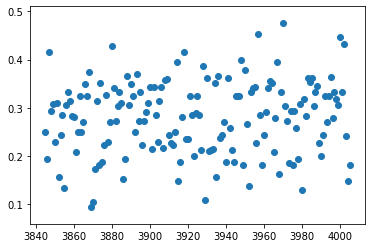

In [407]:
plt.scatter(check_df[check_df.team == 'SEA'].index, 
            check_df[check_df.team == 'SEA'].H/check_df[check_df.team == 'SEA'].AB)
print(np.corrcoef(check_df[check_df.team == 'SEA'].index, 
                  check_df[check_df.team == 'SEA'].H/check_df[check_df.team == 'SEA'].AB)[0][1])

0.06780499642699063

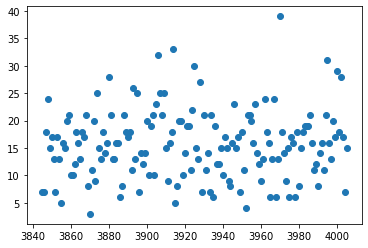

In [408]:
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)
import numpy as np
np.corrcoef(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)[0][1]

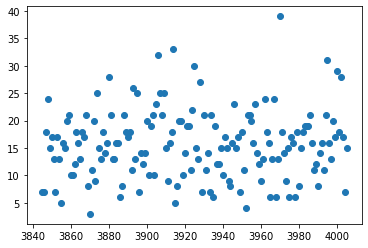

In [409]:
plt.scatter(check_df[check_df.team == 'SEA'].index, check_df[check_df.team == 'SEA'].TB)

0.3911805582664684


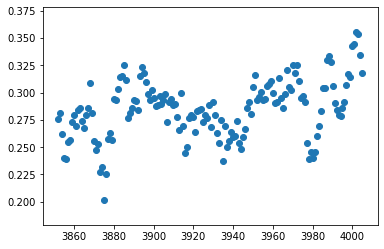

In [410]:
# However when we use a 7 day we get up to .39 R
plt.scatter(check_df[check_df.team == 'SEA'].index[7:], 
            (check_df[check_df.team == 'SEA'].H.rolling(7).sum()/check_df[
                      check_df.team == 'SEA'].AB.rolling(7).sum()).reset_index(drop = True)[7:])
print(np.corrcoef(check_df[check_df.team == 'SEA'].index[7:], 
                  (check_df[check_df.team == 'SEA'].H.rolling(7).sum()/check_df[
                      check_df.team == 'SEA'].AB.rolling(7).sum()).reset_index(drop = True)[7:])[0][1])

-0.040580986310728484


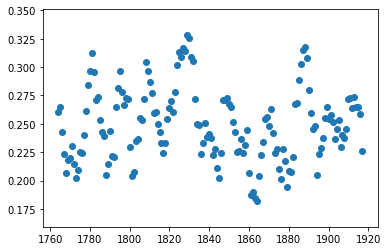

In [411]:
# Not always right...
check_df = batting_df_test[batting_df_test.Y == 2018].reset_index()
plt.scatter(check_df[check_df.team == 'HOU'].index[7:], 
            (check_df[check_df.team == 'HOU'].H.rolling(7).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(7).sum()).reset_index(drop = True)[7:])
print(np.corrcoef(check_df[check_df.team == 'HOU'].index[7:], 
                  (check_df[check_df.team == 'HOU'].H.rolling(7).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(7).sum()).reset_index(drop = True)[7:])[0][1])

-0.052403969183252776


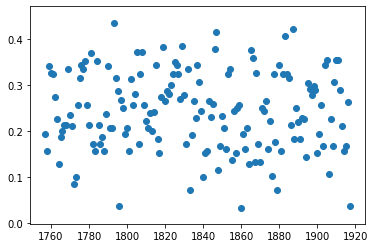

In [412]:
# Not always right...
check_df = batting_df_test[batting_df_test.Y == 2018].reset_index()
plt.scatter(check_df[check_df.team == 'HOU'].index[0:], 
            (check_df[check_df.team == 'HOU'].H.rolling(1).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(1).sum()).reset_index(drop = True)[0:])
print(np.corrcoef(check_df[check_df.team == 'HOU'].index[0:], 
                  (check_df[check_df.team == 'HOU'].H.rolling(1).sum()/check_df[
                      check_df.team == 'HOU'].AB.rolling(1).sum()).reset_index(drop = True)[0:])[0][1])

In [414]:
check_df.head()

,team,date,AB,RS,H,HR,TB,BB,SF,Y
0,ANA,20180329,46,4,13,3,26,1,0,2018
1,ANA,20180330,32,2,6,1,9,0,0,2018
2,ANA,20180331,41,7,12,0,20,2,0,2018
3,ANA,20180401,38,6,13,0,17,2,0,2018
4,ANA,20180402,34,0,6,0,7,4,0,2018


### Integrating pitchers
Time to integrate pitchers??

In [415]:
AVG_COV_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_AVG.csv').set_index('date')
OBP_COV_DF= pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_OBP.csv').set_index('date')
SLG_COV_DF= pd.read_csv(PATH_TO_OUTPUT_DATA + 'covariates/COVARIATE_SLG.csv').set_index('date')

In [416]:
AVG_COV_DF

,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,...,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
date,,,,,,,,,,,,,,,,,,,,,
20010401,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010402,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010403,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010404,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
20010405,0.277406,0.263385,0.268227,0.269526,0.265407,0.283532,0.254189,0.272199,0.285689,0.290176,...,0.249414,0.264954,0.251828,0.267280,0.276079,0.267825,0.255143,0.281519,0.273459,0.264347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190925,0.244813,0.228571,0.238298,0.236364,0.261029,0.333333,0.219008,0.216667,0.248963,0.232210,...,0.211111,0.214876,0.185345,0.190476,0.214815,0.231579,0.250000,0.238298,0.221344,0.258303
20190926,0.225806,0.228571,0.238298,0.236364,0.261029,0.327138,0.227273,0.223140,0.235043,0.234432,...,0.200000,0.248000,0.165939,0.180723,0.211538,0.231579,0.250000,0.242553,0.221344,0.259259
20190927,0.220408,0.219424,0.252101,0.230769,0.266160,0.327138,0.242798,0.214286,0.200873,0.237918,...,0.199301,0.252066,0.173160,0.168067,0.212928,0.226148,0.243028,0.253112,0.200803,0.273063


In [125]:
drop_labels = ['home_' + str(x) + '_id' for x in range(1, 10)] + ['away_' + str(x) + '_id' for x in range(1, 10)]

game_df_new = game_df.drop(columns = drop_labels, axis = 1)